In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import pickle

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [102]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.float", "{:.2f}".format)
warnings.filterwarnings(action='ignore')

In [4]:
# 한글폰트적용
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'

# Load dataset

In [5]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

In [41]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


`movies` 데이터세트는 영화 이름 및 영화의 장르 등의 정보를 담고 있습니다.

In [42]:
ratings.head()

,Unnamed: 0,userId,movieId,rating,timestamp
0,0,281763,16,5.0000,1343764707
1,1,281763,25,4.0000,1343764477
2,2,281763,70,3.5000,1343500770
3,3,281763,111,5.0000,1343503625
4,4,281763,235,4.0000,1343764535


`ratings` 데이터 세트는 유저들이 자신들이 시청한 영화에 대해 매긴 점수(rating)에 대한 정보를 담고 있습니다.

# EDA & Feature engineering

In [6]:
data = ratings.merge(movies, how='left', on='movieId')
data = data[data['rating'] >= 4]
data.drop(data.columns.tolist()[0], axis=1, inplace=True)

In [100]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,281763,16,5.00,1343764707,Casino (1995),Crime|Drama
1,281763,25,4.00,1343764477,Leaving Las Vegas (1995),Drama|Romance
3,281763,111,5.00,1343503625,Taxi Driver (1976),Crime|Drama|Thriller
4,281763,235,4.00,1343764535,Ed Wood (1994),Comedy|Drama
5,281763,296,4.50,1343764750,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


분석을 진행하기 위해 두 데이터세트를 병합한 후에 `rating`이 4점이상인 데이터만을 필터링 하였습니다.

In [52]:
print('No. observations: {:,}'.format(data.shape[0]))
print('No. movies in the dataset: {:,}'.format(data['title'].nunique()))

No. observations: 69,265
No. movies in the dataset: 6,940


# Project①: 인터스텔라(2014)를 좋아하는 사람들에게 추천해 줄 영화는?

In [83]:
uid = data['userId'].unique()

titles = [list(data[data['userId'] == u]['title']) for u in uid]

In [84]:
encoder = TransactionEncoder().fit(titles)

titles_onehot = encoder.transform(titles)
titles_onehot = pd.DataFrame(titles_onehot, columns=encoder.columns_)

In [85]:
titles_onehot = pd.read_csv('titles_onehot.csv')
titles_onehot.drop(titles_onehot.columns[0], axis=1, inplace=True)

In [99]:
frequent_itemsets = apriori(titles_onehot,
                           min_support=0.02,
                           use_colnames=True, max_len=2)

frequent_itemsets

,support,itemsets
0,0.03,((500) Days of Summer (2009))
1,0.02,(10 Things I Hate About You (1999))
2,0.05,(12 Angry Men (1957))
3,0.08,(2001: A Space Odyssey (1968))
4,0.04,(28 Days Later (2002))


In [87]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=0)

영화간에 연관규칙을 만들었습니다.

In [88]:
rules['antecedents'] = rules['antecedents'].apply(lambda x: ','.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ','.join(list(x)))

In [116]:
interstellar_rules = rules[rules['antecedents'].str.contains('Interstellar')].sort_values('conviction', ascending=False)[:5]
interstellar_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
11360,Interstellar (2014),Inception (2010),0.05,0.12,0.04,0.74,6.35,0.03,3.44
6543,Interstellar (2014),"Dark Knight, The (2008)",0.05,0.13,0.03,0.60,4.75,0.03,2.20
11896,Interstellar (2014),"Matrix, The (1999)",0.05,0.24,0.03,0.62,2.60,0.02,1.99
8440,Interstellar (2014),Fight Club (1999),0.05,0.20,0.03,0.59,3.00,0.02,1.96
11903,Interstellar (2014),"Shawshank Redemption, The (1994)",0.05,0.32,0.03,0.63,1.95,0.02,1.82


Antecedent가 인터스텔라인 영화 중 가장 인기가 높은 영화(전체 관람객중 10% 이상이 시청한 영화)를 confidence를 기준으로 내림차순 정렬합니다.

In [125]:
heatmap_interstella = interstellar_rules.pivot(index='antecedents', columns='consequents', values='confidence').T.sort_values('Interstellar (2014)', ascending=False).T

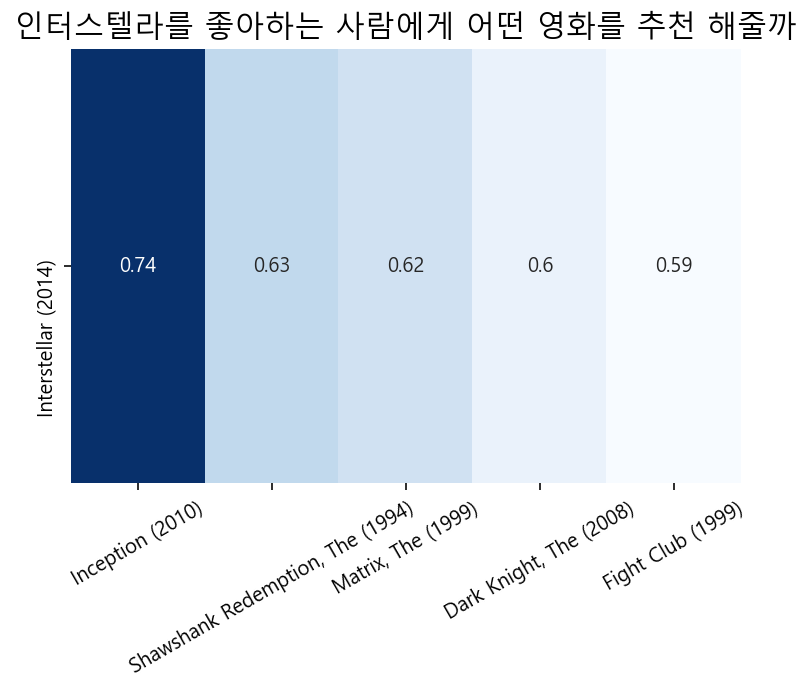

In [126]:
_=sns.heatmap(heatmap_interstella.round(2), cmap='Blues',
           annot=True, cbar=False)
_=plt.xticks(rotation=30)
_=plt.xlabel(None)
_=plt.ylabel(None)
_=plt.title("인터스텔라를 좋아하는 사람에게 어떤 영화를 추천 해줄까", fontdict={'fontsize':15})

인터스텔라를 좋아하는 사람은 인셉션(2010), 다크나이트(2008), 매트릭스(1999), 파이트클럽(1999), 쇼생크탈출(1994) 등의 영화도 선호하는 것으로 나타났습니다.

# Project②: 장르간 선호관계

In [8]:
genres_df = data[['userId', 'genres']]
genres_df.head()

,userId,genres
0,281763,Crime|Drama
1,281763,Drama|Romance
3,281763,Crime|Drama|Thriller
4,281763,Comedy|Drama
5,281763,Comedy|Crime|Drama|Thriller


In [9]:
genres_df['genres'] = '|' + genres_df['genres'].astype(str)
genres_df = genres_df.groupby('userId', as_index=False).sum()

데이터를 전처리해 줍니다.

In [16]:
genres_lists = list(genres_df['genres'].apply(lambda x: x.split('|')))

for inlist in genres_lists:
    temp = inlist[0]
    inlist.remove(temp)

In [101]:
encoder2 = TransactionEncoder().fit(genres_lists)
genres_onehot = pd.DataFrame(encoder2.transform(genres_lists), columns=encoder2.columns_)

In [20]:
genres_onehot.drop(genres_onehot.columns[0], axis=1, inplace=True)

In [26]:
genres_frequents = apriori(genres_onehot,
                          max_len=2, use_colnames=True)

genres_rules = association_rules(genres_frequents, metric='lift', min_threshold=0)

In [28]:
genres_rules['antecedents'] = genres_rules['antecedents'].apply(lambda x: ','.join(list(x)))
genres_rules['consequents'] = genres_rules['consequents'].apply(lambda x: ','.join(list(x)))

In [41]:
def zhang(ante, conse):
    """Calculates zhang's metric"""
    supportA = ante.mean()
    supportC = conse.mean()
    supportAC = np.logical_and(ante, conse).mean()
    
    num = supportAC - supportA*supportC
    denom = max(supportAC*(1-supportA), supportA*(supportC-supportAC))
    
    return num/denom

In [47]:
zhangs_metric =[]

for i in np.arange(len(genres_rules)):
    ante = genres_rules['antecedents'][i]
    conse = genres_rules['consequents'][i]
    zhangs_metric.append(zhang(genres_onehot[ante], genres_onehot[conse]))

In [49]:
genres_rules['zhang'] = zhangs_metric

In [103]:
genres_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhang
0,Adventure,Action,0.83,0.87,0.79,0.95,1.10,0.07,2.86,0.52
1,Action,Adventure,0.87,0.83,0.79,0.91,1.10,0.07,1.89,0.68
2,Action,Animation,0.87,0.55,0.52,0.60,1.10,0.05,1.13,0.68
3,Animation,Action,0.55,0.87,0.52,0.95,1.10,0.05,2.83,0.19
4,Children,Action,0.61,0.87,0.57,0.94,1.08,0.04,2.11,0.19
...,...,...,...,...,...,...,...,...,...,...
155,Thriller,Sci-Fi,0.87,0.75,0.71,0.82,1.09,0.06,1.39,0.64
156,War,Sci-Fi,0.65,0.75,0.56,0.86,1.14,0.07,1.74,0.35
157,Sci-Fi,War,0.75,0.65,0.56,0.74,1.14,0.07,1.35,0.50
158,War,Thriller,0.65,0.87,0.61,0.94,1.08,0.05,2.27,0.22


장르간의 연관규칙을 생성하고, zhang metric을 추가하였습니다.

### 가장 인기 많은 영화 장르 Top3

In [79]:
pd.DataFrame(genres_onehot.mean().sort_values(ascending=False)[:3], columns=[''])

,
Drama,0.96
Comedy,0.90
Action,0.87


전체 관람객 중 96%가 드라마 장르의 영화를 시청하였습니다.

### 가장 인기 없는 영화 장르 Top3

In [80]:
pd.DataFrame(genres_onehot.mean().sort_values()[:3], columns=[''])

,
Documentary,0.20
Film-Noir,0.23
Western,0.37


전체 관람객 중 오직 20%만이 다큐멘터리 장르의 영화를 시청하였습니다.

### 장르간 선호 관계

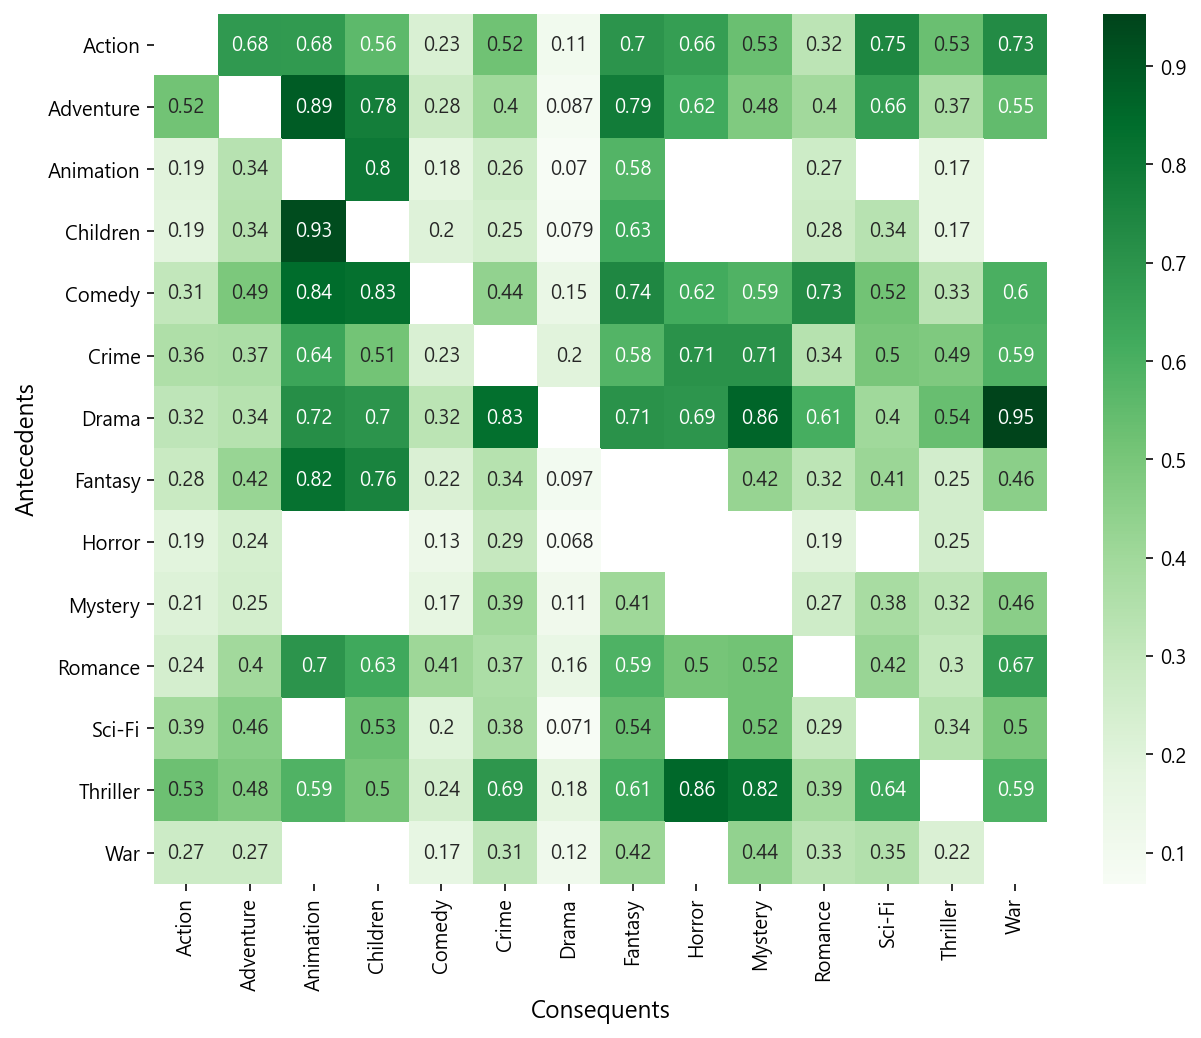

In [74]:
_=plt.figure(figsize = (10, 8))
_=sns.heatmap(genres_rules.pivot(index='antecedents',
                  columns='consequents',
                  values='zhang'), annot=True, cmap='Greens')

_=plt.xlabel('Consequents', fontdict={'fontsize':12})
_=plt.ylabel('Antecedents', fontdict={'fontsize':12})

Zhang metric을 이용하여 개체간 연관(선호, 불호)관계를 시각화 하였습니다.

* 액션 영화를 좋아하는 사람들 중 70%가 판타지 영화도 좋아한다.
* 코미디 영화를 좋아하는 사람들 중 73%가 로맨스 영화도 좋아한다.
* 어린이 영화를 좋아하는 사람들 중 오직 7.9% 만이 드라마 장르 영화를 좋아한다.